In [1]:
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from tqdm import tqdm
from funcs import *

In [2]:
df = load_filtered_fits("/Users/calvinsridhara/Documents/GitHub/M33_Analysis/Tables/m33_vels_stars_inc22B_donedupes.fits")
report_sel_flag_combinations(df)

Number of stars for each SEL flag combination:
RGB_SEL: 2361
AGB_SEL: 642
OHB_SEL: 475
RHB_SEL: 636
YMS_SEL: 308
OHB_SEL, WCN_SEL: 44
AGB_SEL, CBN_SEL: 144
RHB_SEL, WCN_SEL: 475
CBN_SEL, RHB_SEL: 10
RGB_SEL, WCN_SEL: 57
AGB_SEL, WCN_SEL: 58
CBN_SEL, RGB_SEL: 21
WCN_SEL, YMS_SEL: 4
None: 20
WCN_SEL: 1


In [3]:
import pandas as pd

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 200)

# Filter for extreme high or low VCORR_STAT
extreme_vcorr = df[(df['VCORR_STAT'] > 1000) | (df['VCORR_STAT'] < -1000)]
df = df[(df['VCORR_STAT'] <= 1000) & (df['VCORR_STAT'] >= -1000)]
#Print full details
print(extreme_vcorr)

        OBJNAME SLITNAME MASKNAME        DATE         Z     Z_ERR  ZQUALITY           RA          DEC   AIRMASS         SN         ABAND GRATING     RA_DEG    DEC_DEG  \
889      145574      216   M33D4B  2016-09-26  0.737867  0.000016         4  01:33:42.88  +30:20:32.9  1.640700  13.783641  1.502037e-05   600ZD  23.428667  30.342472   
2448  RGB_62343      126   E2M33R  2019-12-02  2.558934 -2.000000         4  01:33:50.09  +30:47:47.4  1.135014   2.671302  7.152557e-07   1200G  23.458708  30.796500   
3327     696070      118     pTN5  2020-11-08  2.164608 -1.000000         4  01:35:17.17  +31:13:10.3  1.675846   0.000000  5.960464e-07   1200G  23.821542  31.219528   
4386     925489       44     pTH2  2021-09-12  0.067714  0.000014         3  01:31:56.82  +31:28:43.9  1.128898   3.215741 -2.439618e-04   1200G  22.986750  31.478861   

                                             zspecnotes           VRAW           VERR         VHELIO          VCORR     VCORR_STAT    MASK_X  ABAND_S

In [4]:
df = classify_age_groups(df) #Classiy Stars By age group

Number of stars in each age group:
age_group
old                  2360
young_unconfirmed    1109
young                 947
int                   816
unclassified           20
Name: count, dtype: int64


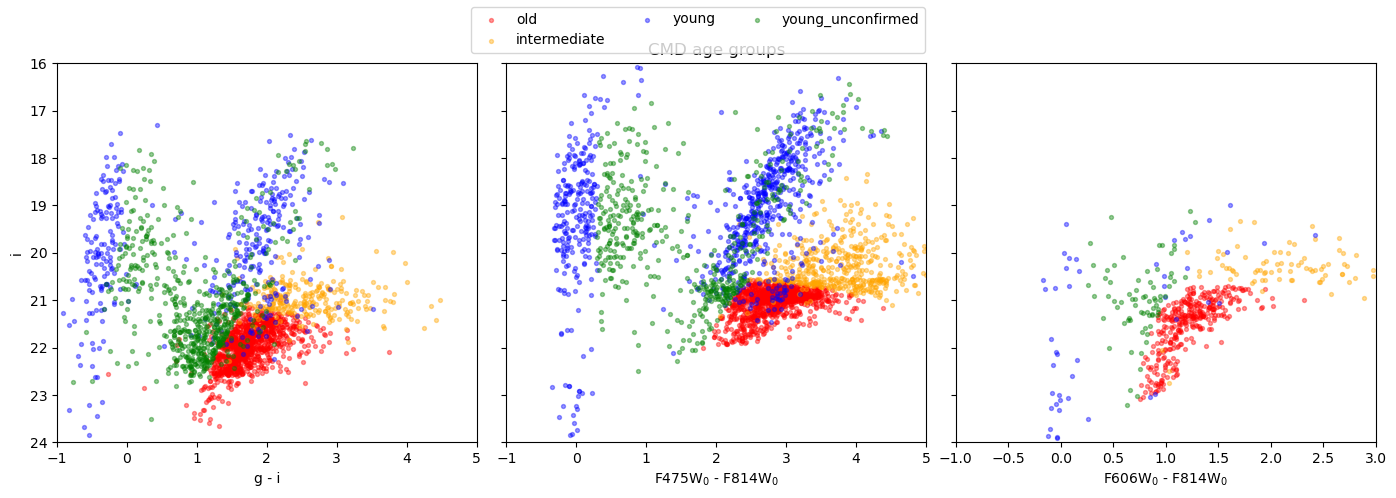

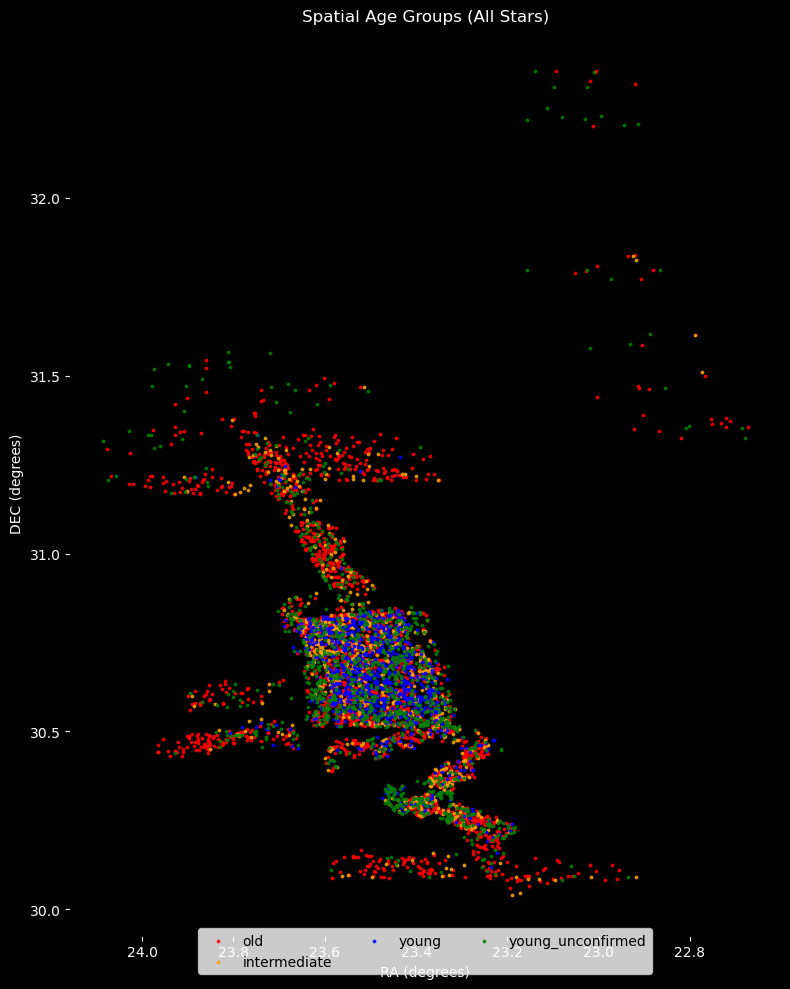

In [5]:
plot_cmd_panels(df) # Plot Color-MAgnitude Diagram
plot_spatial_age_groups(df) # Plot RA-DEC Plot

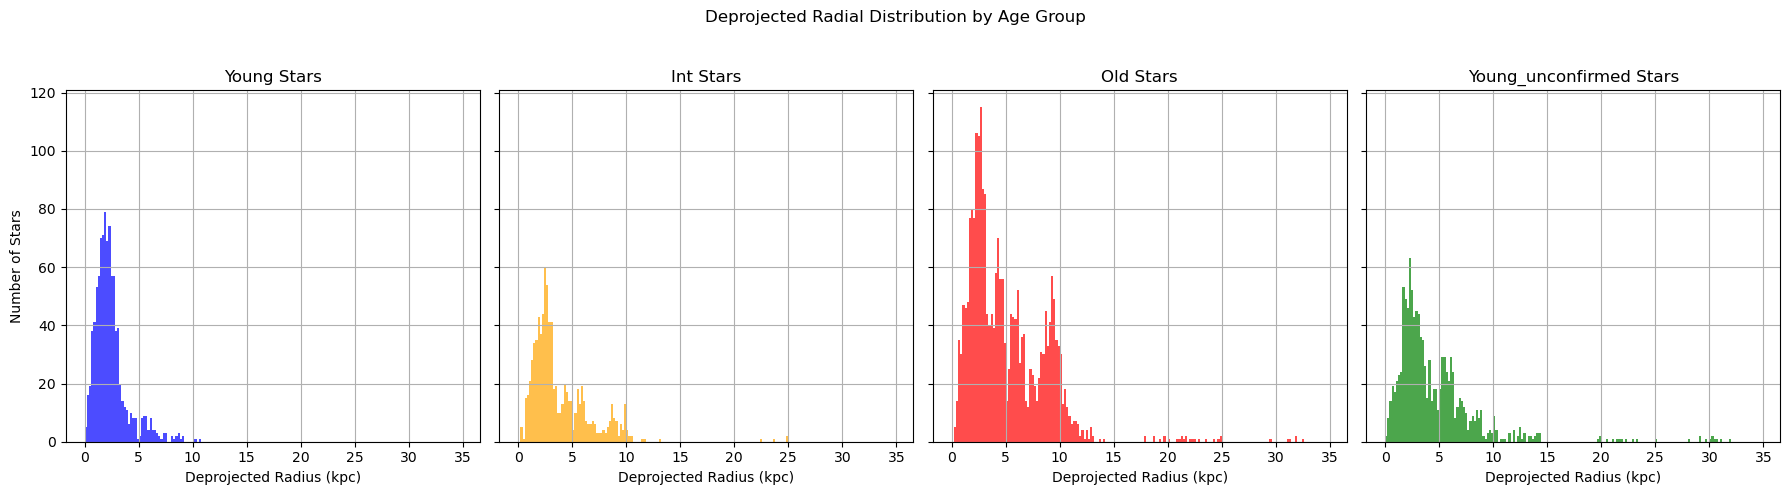

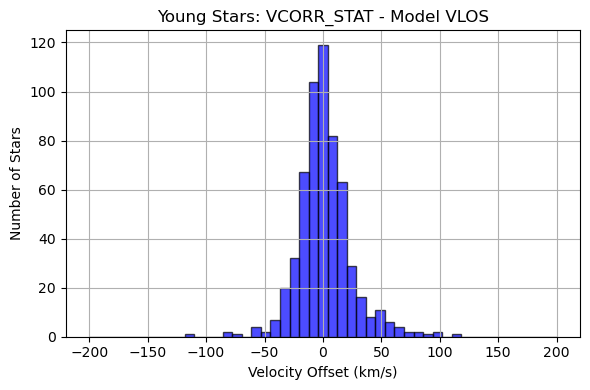

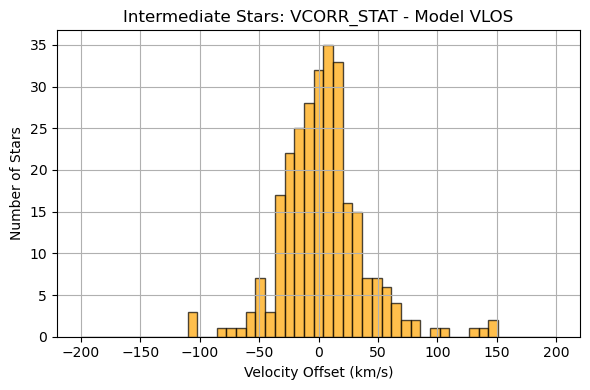

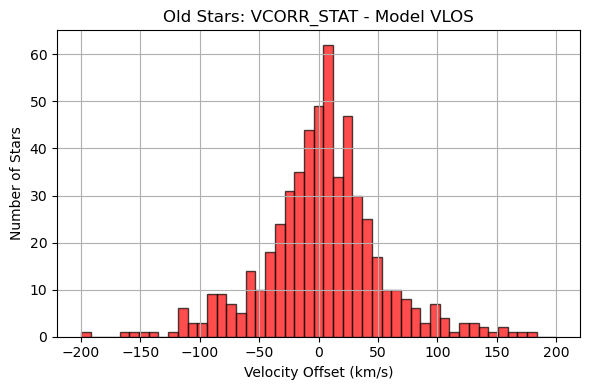

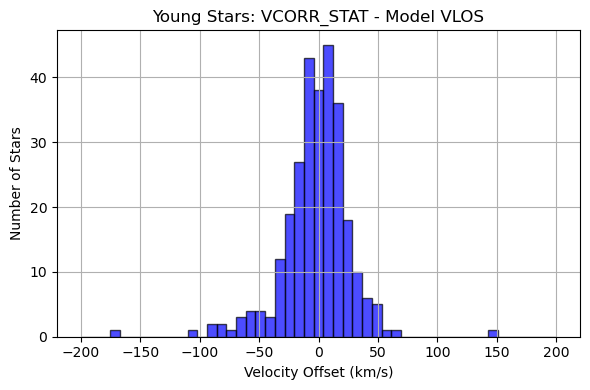

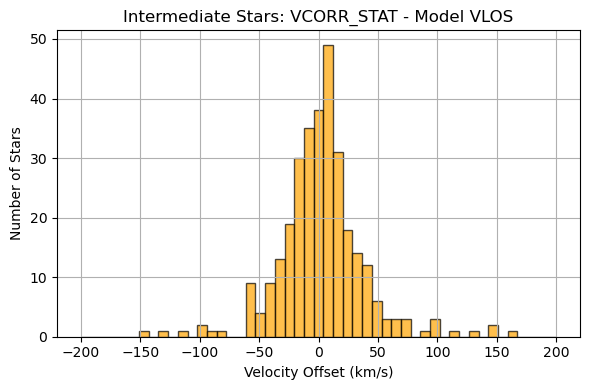

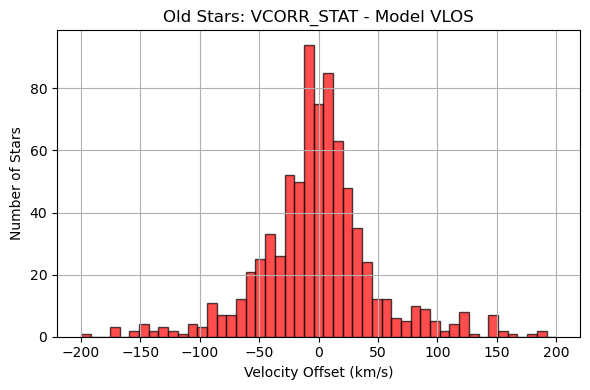

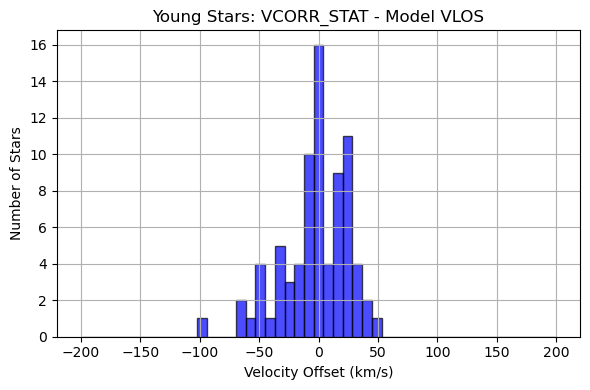

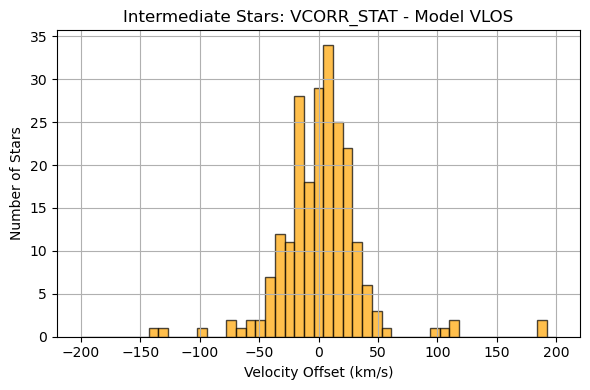

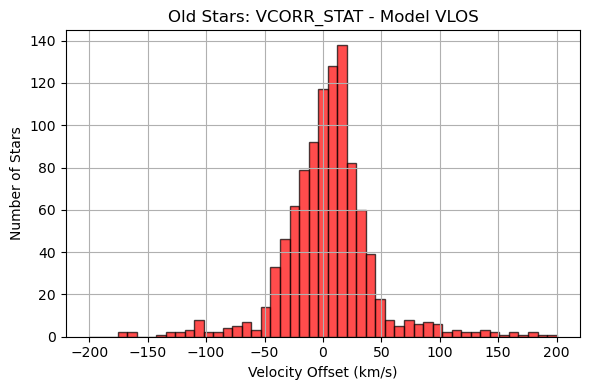

In [6]:
df = compute_deprojected_radius(df) # Find Deprojected radius of a star from the center of M33
plot_radial_distribution_by_age(df) # Plot each by age

df_radial = assign_radial_thirds_equal_count(df) # Assign radial thirds
radial_summaries = generate_radial_third_velocity_summaries(df_radial) # Give Velo
plot_all_voffset_histograms(radial_summaries) # Plot V-offset



In [7]:
double_df = match_doubles(df) #Match Doubles
#plot_spatial(double_df) #Plot Doubles
triplet_df = match_triplets(df)              # Match triplets
#plot_spatial(triplet_df)            # Plot them

Matching doubles (young base): 100%|█████████| 947/947 [00:00<00:00, 976.33it/s]


Matched young–old pairs found: 791


Matching triplets (young base): 100%|████████| 947/947 [00:01<00:00, 705.75it/s]

Matched triplets found: 509


In [8]:
triplet_summary = generate_summary_with_model_vlos(triplet_df)
double_summary = generate_summary_with_model_vlos(double_df)
#print(triplet_summary.head())
#print(double_summary.head())

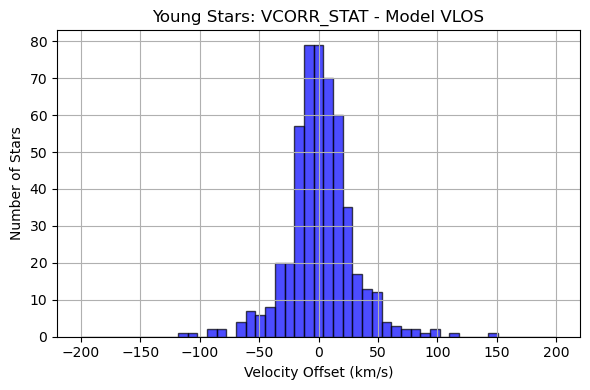

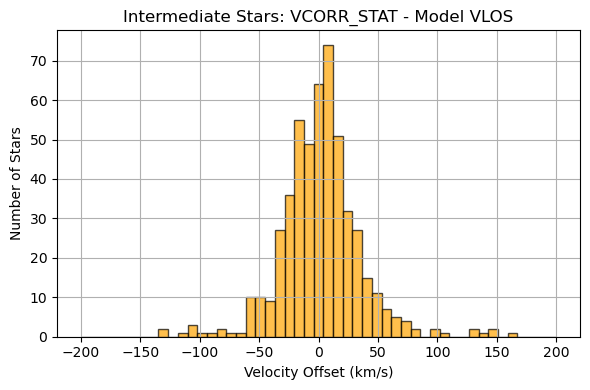

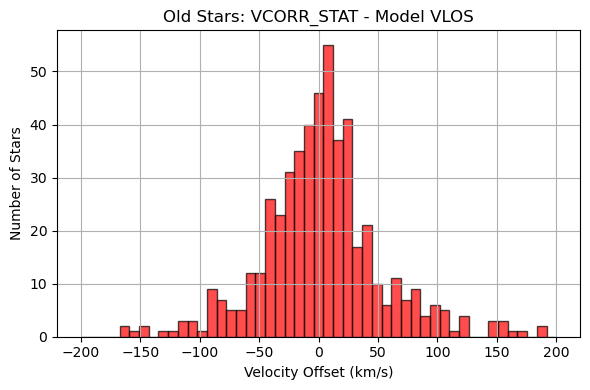

In [9]:
plot_voffset_hist_young(triplet_summary)
plot_voffset_hist_intermediate(triplet_summary)
plot_voffset_hist_old(triplet_summary)

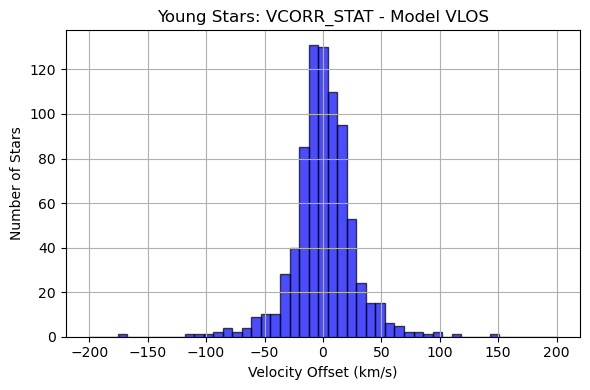

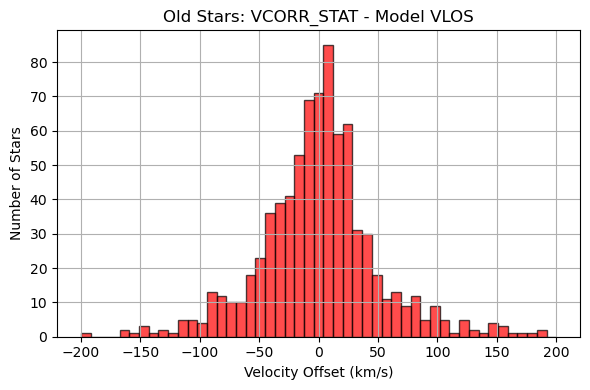

In [10]:
plot_voffset_hist_young(double_summary)
plot_voffset_hist_old(double_summary)

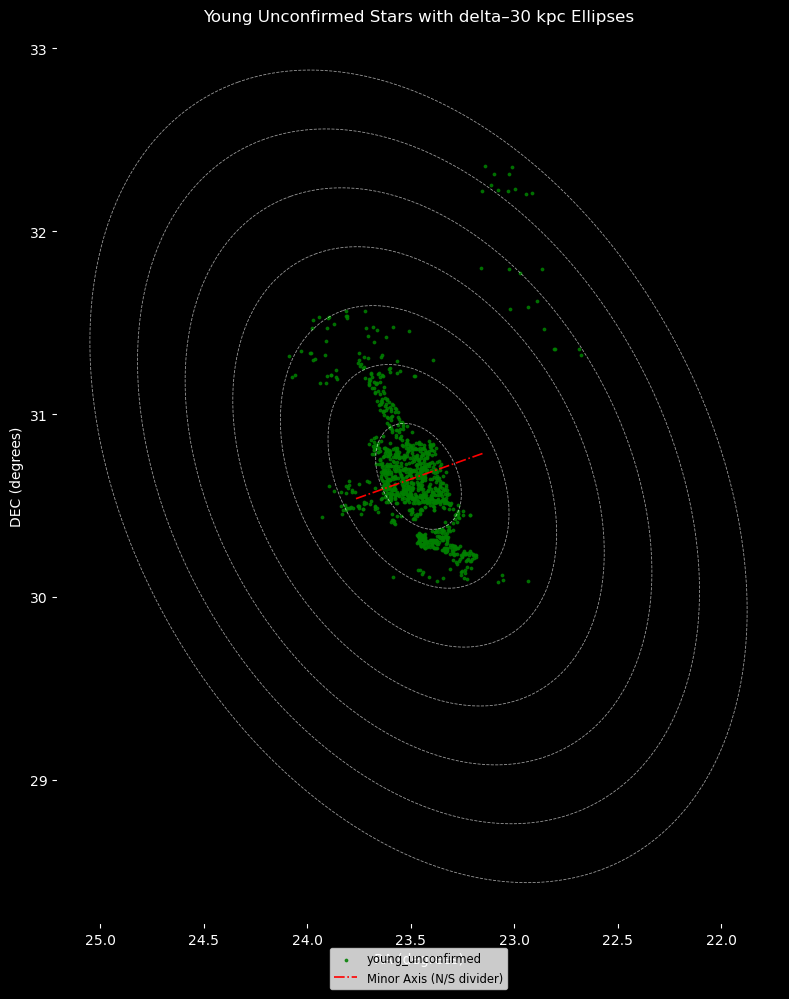

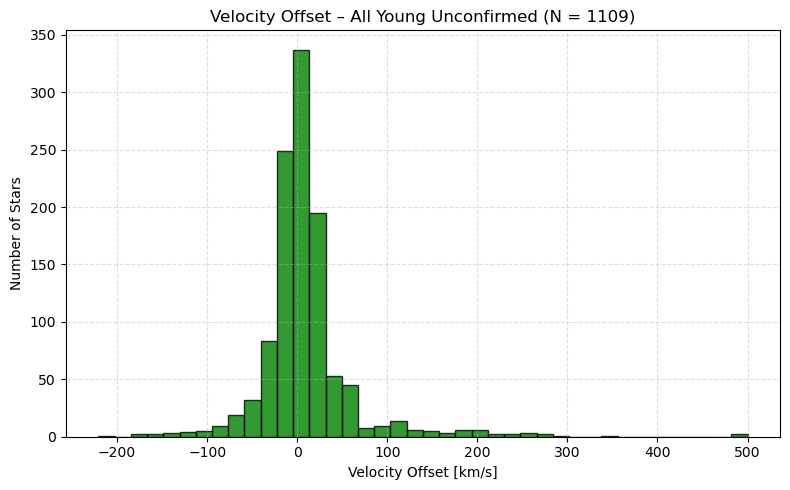

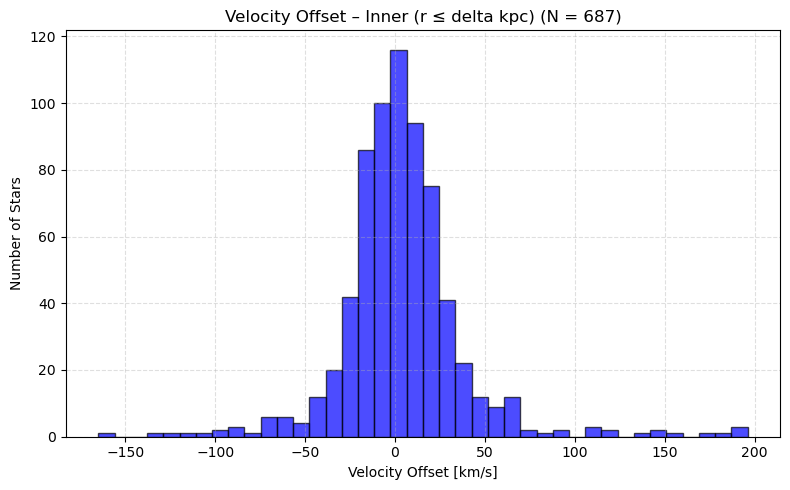

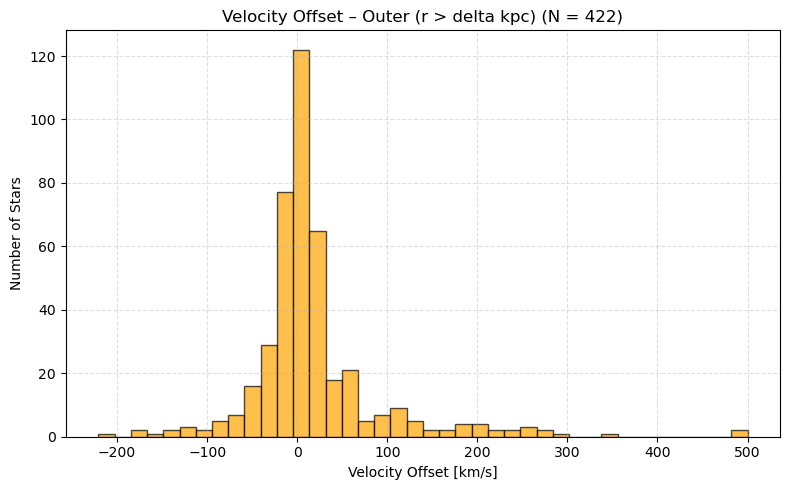

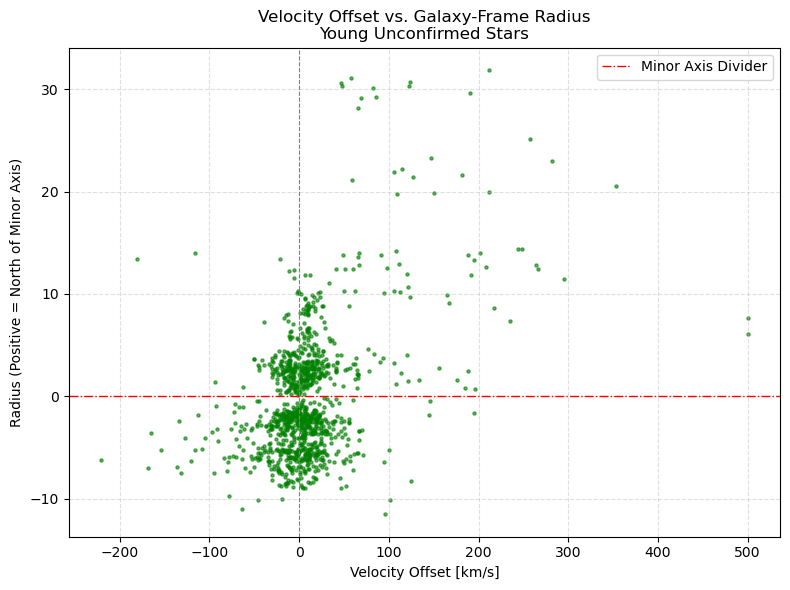

Stars with V_offset > 500 km/s:
         RA_DEG    DEC_DEG  VCORR_STAT     V_model     V_offset
2669  23.628167  31.149528  291.072257 -267.346303   558.418559
2899  23.583417  31.049667  794.961519 -264.455235  1059.416754


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.table import Table

delta = 4.5

df_young_unconfirmed = df[df['age_group'] == 'young_unconfirmed'].copy()
coords = SkyCoord(ra=df_young_unconfirmed['RA_DEG'].values * u.deg, dec=df_young_unconfirmed['DEC_DEG'].values * u.deg)
df_young_unconfirmed = compute_deprojected_radius(df_young_unconfirmed)

diskmodel = load_disk_model('./Kam2017_table4.dat')


df_young_unconfirmed['V_model'] = compute_model_los_velocity(coords, diskmodel)
df_young_unconfirmed['V_offset'] = df_young_unconfirmed['VCORR_STAT'] - df_young_unconfirmed['V_model']

# Plot 1: RA/DEC with Ellipses and Minor Axis Divider
plt.figure(figsize=(8, 10), facecolor='black')
ax = plt.gca()
ax.set_facecolor('black')
plt.scatter(df_young_unconfirmed['RA_DEG'], df_young_unconfirmed['DEC_DEG'],
            color='green', s=3, alpha=0.8, label='young_unconfirmed')

r_deproj_kpc_values = np.arange(delta, 35, 5)
for r_deproj_kpc_ellipse in r_deproj_kpc_values:
    r_arcmin = (r_deproj_kpc_ellipse / distance_kpc) * (180 / np.pi) * 60
    theta = np.linspace(0, 2 * np.pi, 500)
    alpha = r_arcmin * np.cos(theta)
    beta = r_arcmin * np.sin(theta) * np.cos(inc_rad)
    xi_ell = alpha * np.sin(PA_rad) + beta * np.cos(PA_rad)
    eta_ell = alpha * np.cos(PA_rad) - beta * np.sin(PA_rad)
    ra_ellipse = center.ra.degree + xi_ell / 60.0
    dec_ellipse = center.dec.degree + eta_ell / 60.0
    plt.plot(ra_ellipse, dec_ellipse, linestyle='--', color='white', linewidth=0.6, alpha=0.6)

r_line = np.linspace(-20, 20, 100)
alpha = np.zeros_like(r_line)
beta = r_line
xi_line = alpha * np.sin(PA_rad) + beta * np.cos(PA_rad)
eta_line = alpha * np.cos(PA_rad) - beta * np.sin(PA_rad)
ra_line = center.ra.degree + xi_line / 60.0
dec_line = center.dec.degree + eta_line / 60.0
plt.plot(ra_line, dec_line, color='red', linestyle='-.', linewidth=1.2, label='Minor Axis (N/S divider)')

plt.xlabel("RA (degrees)", color='white')
plt.ylabel("DEC (degrees)", color='white')
plt.tick_params(colors='white')
ax.invert_xaxis()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.08), fontsize='small')
plt.title("Young Unconfirmed Stars with delta–30 kpc Ellipses", color='white')
plt.tight_layout()
plt.show()

# Plot 2: Velocity Offset Histogram (All)
plt.figure(figsize=(8, 5))
vclip_all = df_young_unconfirmed['V_offset'].clip(-300, 500)
plt.hist(vclip_all, bins=40, color='green', alpha=0.8, edgecolor='black')  # removed density=True
plt.xlabel('Velocity Offset [km/s]')
plt.ylabel('Number of Stars')
plt.title(f'Velocity Offset – All Young Unconfirmed (N = {len(vclip_all)})')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Plot 3: Inner r ≤ r_deproj_kpc kpc
inner_mask = df_young_unconfirmed['r_deproj_kpc'] <= delta
vclip_inner = df_young_unconfirmed.loc[inner_mask, 'V_offset'].clip(-300, 500)
plt.figure(figsize=(8, 5))
plt.hist(vclip_inner, bins=40, color='blue', alpha=0.7, edgecolor='black')  # removed density=True
plt.xlabel('Velocity Offset [km/s]')
plt.ylabel('Number of Stars')
plt.title(f'Velocity Offset – Inner (r ≤ delta kpc) (N = {len(vclip_inner)})')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Plot 4: Outer r > delta kpc
outer_mask = df_young_unconfirmed['r_deproj_kpc'] > delta
vclip_outer = df_young_unconfirmed.loc[outer_mask, 'V_offset'].clip(-300, 500)
plt.figure(figsize=(8, 5))
plt.hist(vclip_outer, bins=40, color='orange', alpha=0.7, edgecolor='black')  # removed density=True
plt.xlabel('Velocity Offset [km/s]')
plt.ylabel('Number of Stars')
plt.title(f'Velocity Offset – Outer (r > delta kpc) (N = {len(vclip_outer)})')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Plot 5: Velocity Offset vs. Signed Minor-Axis Radius
offset = coords.transform_to(center.skyoffset_frame())
eta = offset.lat.arcminute  # angular offset along the minor axis in arcminutes
sign = np.sign(eta)  # +1 for north, -1 for south

r_deproj_kpc_signed_by_minor = df_young_unconfirmed['r_deproj_kpc'] * sign

plt.figure(figsize=(8, 6))
plt.scatter(df_young_unconfirmed['V_offset'].clip(-300, 500),
            r_deproj_kpc_signed_by_minor, s=5, color='green', alpha=0.6)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)
plt.axhline(0, color='red', linestyle='-.', linewidth=1.0, label='Minor Axis Divider')
plt.xlabel('Velocity Offset [km/s]')
plt.ylabel('Radius (Positive = North of Minor Axis)')
plt.title('Velocity Offset vs. Galaxy-Frame Radius\nYoung Unconfirmed Stars')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Filter stars with V_offset > 500 km/s
high_v_offset_stars = df_young_unconfirmed[df_young_unconfirmed['V_offset'] > 500]

# Display the result
print("Stars with V_offset > 500 km/s:")
print(high_v_offset_stars[['RA_DEG', 'DEC_DEG', 'VCORR_STAT', 'V_model', 'V_offset']])



Fitting disk + halo models to matched triplet stars...

Running modeling for young group...


NameError: name 'spec_direct' is not defined

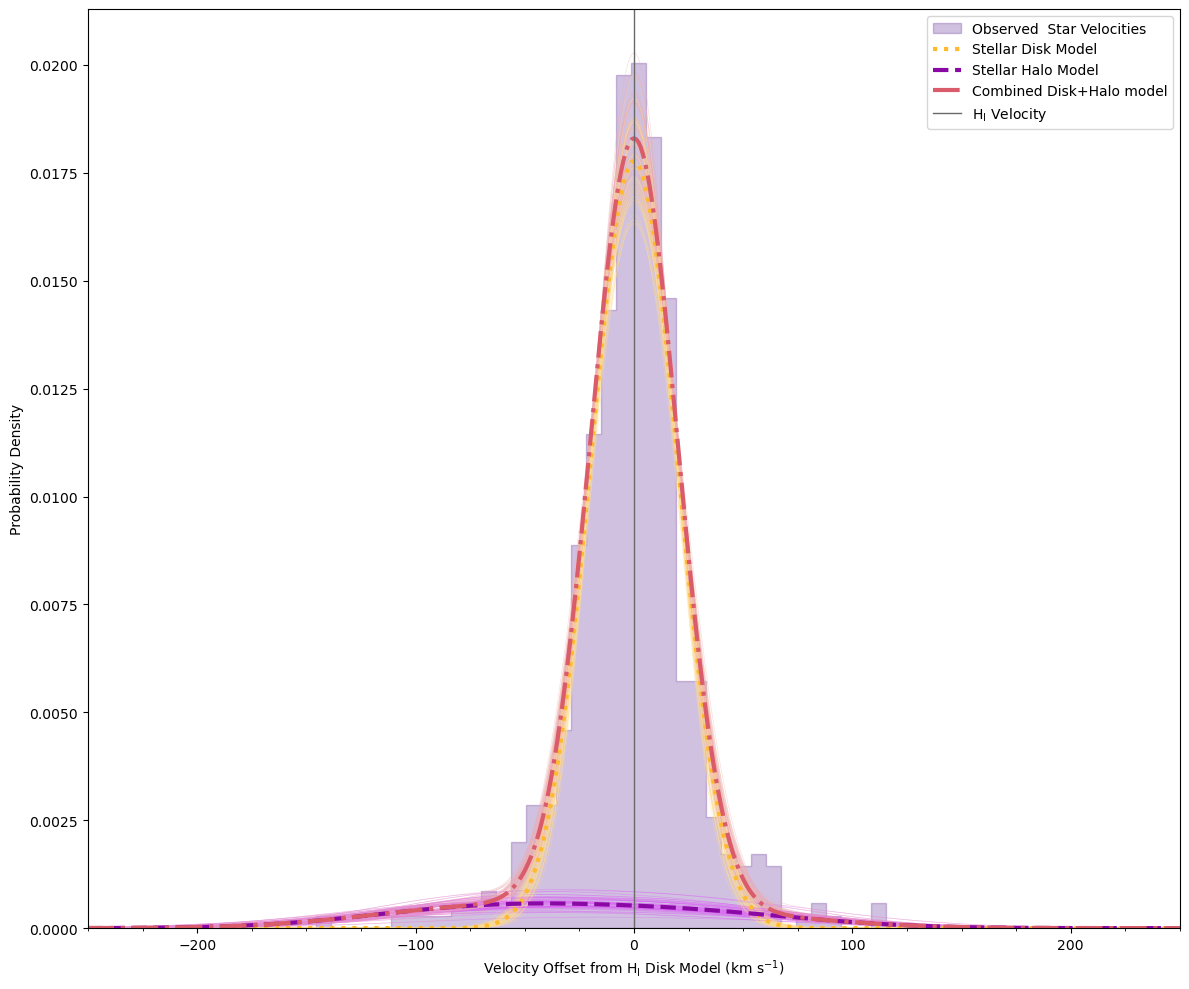

In [60]:
import numpy as np
import dynesty
from dynesty import utils as dyfunc
from dynesty import plotting as dyplot
import corner
import pickle
import math
from astropy.table import Table, Column, vstack
import numpy as np
import matplotlib.colors as mc
import colorsys
import matplotlib.cm as cm
import matplotlib.ticker as ticker


def lighten_color(color, amount=0.5):
	try:
		c = mc.cnames[color]
	except:
		c = color
	c = colorsys.rgb_to_hls(*mc.to_rgb(c))
	return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mc.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmapd = plt.get_cmap('viridis')

def savenice(name,fighandle):
	fighandle.tight_layout()
	fighandle.savefig(name,bbox_inches='tight')
	fig.close()

def distance(dmod):
    dist = 10.**((dmod + 5.)/5.)/10**3
    return dist  #in kpc


set_dict = {1:"LD_SH",2:"NLD_SH",3:"LD_LH",4:"2LD_SH",5:"2LD_LH"}
y_lim_factor = 0.3 # multiplicative factor to add to the max of the 50th % PDF for the y limit for model/data velocity histogram plots
histylabel = 'Probability Density'
legloc='best'
ylim_pdf_pad = 0.2

radinit=50 #arcsec
radmax = 300 #arcsec
nummin=15
pri_disk_dispmax = 50.
pri_halo_dispmax = 100.
pri_hfrac_max = 0.85
pri_frothalomin = -1.3 # allows halo to counter-rotate. maximum inherently 1: can't have halo rotating faster than disk
pri_frotdiskmax = 1.5 # allows disk to rotate faster than HI. minimum inherently 0: don't allow disk to counter-rotate relative to stars
GLPDF_PREFACTOR = -0.5*np.log(2*np.pi)
glpdf = lambda x, mu, sig: GLPDF_PREFACTOR - np.log(sig) - 0.5*((x-mu)/sig)**2

MINF = -np.inf
FAIL_RET = MINF, (None, None)  #useful if blobs come into play...

# #-----------Defines colours used in Karrie's M33 RGB analysis-------
#
# crgb = 'rosybrown'
# # dark model on light draws
# crgb_model = 'firebrick' #'indianred' # was 'firebrick'
# crgb_model_draws = 'lightcoral'
# crgb_modelmean, crgb_modelmeanunc = 'darkred', 'lightsalmon' #'salmon', 'mistyrose' # for plotting mean velocity (e.g., for non-rotating halo)
# # # light model on dark draws
# # crgb_model = 'lightcoral' #'indianred' # was 'firebrick'
# # crgb_model_draws = 'maroon'
#
# cyoung = 'lightsteelblue'
# # dark model on light draws
# cyoung_model = 'mediumblue' #'royalblue'
# cyoung_model_draws = 'cornflowerblue'
# cyoung_modelmean, cyoung_modelmeanunc = 'cadetblue', 'powderblue'
# # # light model on dark draws
# # cyoung_model = 'blue' #'royalblue'
# # cyoung_model_draws = 'midnightblue'
#
# # for anytime need to mark a fiducial value
# csys = 'dimgrey'
#
# # for HI disk velocities
# ch1disk = 'cornflowerblue'
#
# # for plots with multiple components
# cdisk = cyoung_model # was'steelblue'
# cdiskdraws = cyoung_model_draws
# cdisk2 = 'rebeccapurple' # was 'midnightblue'
# cdisk2draws = 'indigo'
#
# # light model on dark draws
# chalo = crgb_model # was 'firebrick'
# chalodraws = crgb_model_draws
# chalo2 = 'rosybrown'
# chalo2draws = 'lightcoral'
#
# # dark model on light draws
# # ctotal = 'tab:green'
# # ctotaldraws = 'palegreen'
# ctotal = 'sienna'
# ctotaldraws = 'orange' # 'sandybrown'
# # # #light model on dark draws
# # ctotal = 'sandybrown'
# # ctotaldraws = 'saddlebrown'
#
# alpha_sep = 1.0
# alpha_comb = 0.3
# alpha_combscatt = 0.75
#
# allrgb50th = 'burlywood'
# allrgbshade= 'oldlace' #'antiquewhite' #'whitesmoke'

# #-----------Defines colours used in Lara's analysis-------
cmapL = truncate_colormap(plt.get_cmap('plasma'),0.00,0.85)
pt_to_get_cols = np.linspace(0,1,4)
col_hexes = cmapL(pt_to_get_cols)
c4fil = tuple(map(tuple,col_hexes[:,0:3]))

#main RGB colour: bluish (mid)
crgb = 'rebeccapurple' #col_hexes[0]
# crgb_model = col_hexes[1]
# crgb_model_draws = lighten_color(col_hexes[1])
# crgb_modelmean, crgb_modelmeanunc = 'darkred', 'lightsalmon' # for plotting mean velocity (e.g., for non-rotating halo)

#main AGB colour: purpleish (bottom)
cyoung = 'rebeccapurple'
# cyoung_model = col_hexes[0]
# cyoung_model_draws = lighten_color(col_hexes[0],0.4)
# cyoung_modelmean, cyoung_modelmeanunc = 'cadetblue', 'powderblue'

#main carbon colour: greenish (top)
# ccarbon = 'mediumseagreen'
# ccarbon_model = col_hexes[2]
# ccarbon_model_draws = lighten_color(col_hexes[2])

# for anytime need to mark a fiducial value
csys = 'dimgrey'

# for HI disk velocities
ch1disk = 'cornflowerblue'

# for plots with multiple components
cdisk = col_hexes[3]
cdiskdraws = lighten_color(col_hexes[3])

chalo = col_hexes[1]
chalodraws = lighten_color(col_hexes[1])

ctotal = col_hexes[2] #closest to fill colour
ctotaldraws = lighten_color(col_hexes[2])

# chalo2 = 'rosybrown'
# chalo2draws = 'lightcoral'
# cdisk2 = 'rebeccapurple'
# cdisk2draws = 'indigo'

alpha_sep = 1.0
alpha_comb = 0.3
alpha_combscatt = 0.75

allrgb50th = 'burlywood'
allrgbshade= 'oldlace' #'antiquewhite' #'whitesmoke'


def major_minor_transform(coords, pa, centercoords = m33coord, return_xi_eta = False):
    # for a given skycoordinate object/array, and passed position angle with units, compute and return coordinates in receding semi-major axis, minor axis plane

    #convert to xi and eta centered on M33
    c_inm33 = coords.transform_to(centercoords.skyoffset_frame())
    xi, eta = c_inm33.lon.degree, c_inm33.lat.degree

    # coordinates transformation: put in coordinates of (receding semi)major and minor axes
    alpha = eta * np.cos(pa) + xi * np.sin(pa) # major axis
    beta =  - eta * np.sin(pa) + xi * np.cos(pa) # minor axis

    if return_xi_eta:
        return alpha, beta, xi, eta
    else:
        return alpha, beta # in degrees

# def major_minor_transform_reverse(alpha, beta, pa, centercoords = m33coord, return_xi_eta = False):
#     # for a receding major axis, minor axis coordinate, and passed position angle with units, compute and return sky coordinates
#     if return_xi_eta:
#         return skycoords, xi, eta
#     else:
#         return skycoords # in degrees


def m33_tilted_ring_deproj_converge(skycoord, iconv, paconv, funcinc, funcpa, verbose=False):
    # given:
    # skycoord  sky coordinate object,
    # iconv, paconv    convergence criteria for inclination and pa
    # funcpa, funcinc   function for inclination and pa as function of ang distance in plane of disk

    # iteratively determine angular distance in plane of disk from revised inclination, PA until change in inclination and PA given estimate of angular distance in plane of disk converges.

    # compute initial values using global average m33 incl, pa
    Rinit = m33_tilted_ring_deproj_radius_init(skycoord)
    alpha, beta = major_minor_transform(skycoord, funcpa(Rinit*60.)*u.degree, centercoords=m33coord)
    ang_dist_0 = np.sqrt(alpha**2 + (beta / np.cos(funcinc(Rinit*60.)*u.degree))**2.) # in degrees

    # incl, pa corresponding to Rinit
    incl_init = funcinc(Rinit*60.)*u.degree
    pa_init = funcpa(Rinit*60.)*u.degree
    # values calculated from first computation of angular distance in plane disk based on incl_init and pa_init
    incl = funcinc(ang_dist_0*60.)*u.degree
    pa = funcpa(ang_dist_0*60.)*u.degree

    delta_incl = abs(incl - incl_init)
    delta_pa = abs(pa - pa_init)

    # compute ang_dist computed with incl, pa
    alpha, beta = major_minor_transform(skycoord, pa, centercoords=m33coord)
    ang_dist = np.sqrt(alpha**2 + (beta / np.cos(incl))**2.) # in degrees

    niter = 0
    while delta_incl > iconv or delta_pa > paconv:
        niter += 1
        incl_p, pa_p = incl, pa
        # first update incl and pa of model for current angular distance
        incl = funcinc(ang_dist*60.)*u.degree
        pa = funcpa(ang_dist*60.)*u.degree
        # now recompute angular distance
        alpha, beta = major_minor_transform(skycoord, pa, centercoords=m33coord)
        ang_dist = np.sqrt(alpha**2 + (beta / np.cos(incl))**2.) # in degrees
        # and recompute deltas
        delta_incl = abs(incl - incl_p)
        delta_pa = abs(pa - pa_p)

    if verbose==True:
        print('Convergence reached in ', niter, ' iterations.')

    return ang_dist, incl, pa

params2 = 'disklag, disksig, fhalo, halocen, halosig, halolag'.split(', ')
def run_nest(vels, modv, extras, loglike_func, priortrans_func, paramlist, fnam, abridged, backflag=False):
	# if backflag==True:
	# 	sampler = dynesty.DynamicNestedSampler(loglike_func, priortrans_func, len(params3),logl_args=[vels,modv,extras,vfg])
	# else:
	# print(loglike_func, priortrans_func, len(paramlist))
	sampler = dynesty.DynamicNestedSampler(loglike_func, priortrans_func, len(paramlist),logl_args=[vels,modv,extras],blob=True)
	# print([vels,modv,extras])

	sampler.run_nested(print_progress=False)
	result = sampler.results
	result_weights = np.exp(result.logwt - result.logz[-1])  # normalized weights. critical for resampling for corner plot.
	samples_equal = dyfunc.resample_equal(result.samples, result_weights)
	# if abridged!='T':

	quantiles = [dyfunc.quantile(samps, [0.16, 0.5, 0.84]) for samps in samples_equal.T]

	if not abridged:
		#replaces plot_autocorr and plot_chains to ensure fit has converged: first checks evidence converged, second checks all parameters converged
		fig, axes = dyplot.runplot(result, color='tab:blue', mark_final_live=False, logplot=True)
		fig.tight_layout()
		fig.savefig(f'{spec_direct}/dyplots/{fnam}_dyrunplot.pdf',bbox_inches='tight')
		plt.close(fig)
		fig, axes = dyplot.traceplot(result, show_titles=True, trace_cmap='viridis', quantiles=None)
		fig.tight_layout()
		fig.savefig(f'{spec_direct}/dyplots/{fnam}_dytraceplot.pdf',bbox_inches='tight')
		plt.close(fig)

	return [result.logz[-1], result.logzerr[-1]], np.array(quantiles), samples_equal,result['blob']
	#returns [evidence, error on evidence], [-1\sigma,50%,+1sigma] for each fitted par, sample "run"/chain (CORRECTLY EQUALLY WEIGHTED), and sample 'blobs' (do these need weighting???? hopefully not since recorded like likelihood)

def distance(dmod):
    dist = 10.**((dmod + 5.)/5.)/10**3
    return dist

m33_sys = -180.0 # pm 1 km/s; vanderMarel et al. 2008; Kam et al. Table 1 \pm 3
# m33_sys_wunit = m33_sys*u.km/u.s
m33_dmod = 24.67 # what Anil assumed  # Kam et al 2017 uses 840 kpc; but tilted ring model in arcmin, so this is not crucial. Alt 24 or 24.75: closest/furthest distances quoted in Kam 2015
m33_dist = distance(m33_dmod)
m33coord = SkyCoord(ra='01h33m50.9s', dec='+30d39m36s', distance=m33_dist*u.kpc, unit=(u.hourangle, u.deg))

m33_pa = (22.5 + 180.0)*u.deg # \pm 1 ; Table 1 Kam 2017; +180 to match definition used in HI model
m33_pa_amanda = (22 + 180.0)*u.deg  # what Amanda assumes for radial deprojection; +180 to match definition used in HI model
m33_inclination_kam = 52.0*u.deg # \pm 3 ; Table 1 Kam 2017
m33_inclination = 54.0*u.deg # what Amanda assumes for radial deprojection

def m33_tilted_ring_deproj_radius_init(coords):
    # given skycoord object or array, compute (zeroth order) the deprojected radius from M33's center assuming an average (single fixed) PA and inclination for M33, return deprojected radius in arcmin

	alpha, beta = major_minor_transform(coords, m33_pa, centercoords=m33coord)
	ang_dist = np.sqrt(alpha**2 + (beta / np.cos(m33_inclination))**2)
	# print('mmtransform in dprojinit done')
	return ang_dist # # in degrees

def m33_tilted_ring_deproj_radius(coords, model=diskmodel, verbose=False):
	# given skycoord object or array compute a zeroth order deprojected radius, then iterate until converge to deprojected radius taking into account disk model (varying) PA and inclination with radius
	# return deprojected radius in arcmin

	converge_i = 0.01*u.degree # convergence criterion in degree
	# 0.025 is 1/4 the change of inclination per resolution element of the model (which is a steady 0.1 degree per 2 arcmin in radius)
	converge_pa = 0.35*u.degree # convergence criterion in degree
	# over radial range of model, PA changes from a steady 201.3 to nearly 160 degrees. decreases fairly quickly though from 201 to ~175 over ~15 arcmin (by ~3.5 deg per 2arcmin)

    # compute zeroth order deprojected radius
	Rinit = m33_tilted_ring_deproj_radius_init(coords) # in degree
	# print('deproj_radius_init in deprojr done')

	# interpolate between Kam et al. 2017 data points for vrot, major axis PA, and inclination for radius in ARCMIN
	# fill_value tells it what to do if outside bounds of data: currently "extrapolate", but ideally set to first,last value in the model
	#f_pa = interp1d(model['Radius_arcmin'], model['PA_deg'], fill_value=(model['PA_deg'][0], model['PA_deg'][-1]))
	#f_incl = interp1d(model['Radius_arcmin'], model['i_deg'], fill_value=(model['i_deg'][0], model['i_deg'][-1]))
	f_pa = interp1d(model['Radius_arcmin'], model['PA_deg'], fill_value="extrapolate")
	f_incl = interp1d(model['Radius_arcmin'], model['i_deg'], fill_value="extrapolate")

	# Do a single iteration from Rinit, this time using appropriate PA and inclination from disk model for deprojected radius of Rinit
	alpha, beta = major_minor_transform(coords, f_pa(Rinit*60.)*u.degree, centercoords=m33coord)
	# print('mmtransform in deprojr done')

	# deprojection needs to happen for minor axis direction
	ang_dist = np.sqrt(alpha**2 + (beta / np.cos(f_incl(Rinit*60.)*u.degree))**2.) # in degrees
	# print(ang_dist,Rinit)

	# values corresponding to Rinit, calculated assuming global, avg values m33_pa and m33_inclination
	incl_init = f_incl(Rinit*60.)*u.degree
	pa_init = f_pa(Rinit*60.)*u.degree
	# values calculated from first computation of angular distance in plane disk based on incl_init and pa_init
	incl = f_incl(ang_dist*60.)*u.degree
	pa = f_pa(ang_dist*60.)*u.degree

	delta_incl = incl - incl_init
	delta_pa = pa - pa_init

	count=0

	# need to somehow manage single value passes
	if len(np.atleast_1d(ang_dist)) > 1:
		for di,dp,c,r,i in zip(delta_incl, delta_pa, coords, Rinit, range(len(np.atleast_1d(ang_dist)))):
			if abs(di) > converge_i or abs(dp) > converge_pa: # both in degree
				# for this star, iterate until reach convergence
				conv_ang_dist, conv_incl, conv_pa = m33_tilted_ring_deproj_converge(c, converge_i, converge_pa, f_incl, f_pa, verbose=verbose)
				if verbose:
					print('Above a convergence criterion, delta_inclination is: ', di, ' delta_pa is: ', dp)
					print(r, ' -> ', conv_ang_dist)
				# update values for this star using converged values
				ang_dist[i] = conv_ang_dist
				incl[i] = conv_incl
				pa[i] = conv_pa
			elif abs(di) <= converge_i and abs(dp) <= converge_pa:
				count+=1
			else:
				print('Something broke')
		# print('deproj_converge loop done')
	else: # only one coordinate was passed
		if abs(delta_incl) > converge_i or abs(delta_pa) > converge_pa: # both in degree
			# for this star, iterate until reach convergence
			conv_ang_dist, conv_incl, conv_pa = m33_tilted_ring_deproj_converge(coords, converge_i, converge_pa, f_incl, f_pa, verbose=verbose)
			if verbose:
				print('Above a convergence criterion, delta_inclination is: ', delta_incl, ' delta_pa is: ', delta_pa)
				print(r, ' -> ', conv_ang_dist)
			# update values for this star using converged values
			ang_dist = conv_ang_dist
			incl = conv_incl
			pa = conv_pa
		elif abs(delta_incl) <= converge_i and abs(delta_pa) <= converge_pa:
			count+=1
		else:
			print('Something broke')
	if verbose:
		print('Number of stars where first iteration is\n < convergence criterion for both inclination (', converge_i, ') and PA (',
              converge_pa, ') is: ', count)
		print('Total number of stars: ', len(delta_incl))

    # return final ang_dist array
	alpha, beta = major_minor_transform(coords, f_pa(ang_dist*60.)*u.degree, centercoords=m33coord)
	ang_dist2 = np.sqrt(alpha**2 + (beta / np.cos(f_incl(ang_dist*60.)*u.degree))**2.) # in degrees

	return ang_dist2, Rinit, incl, pa # all in degrees, incl and pa have units attached

def m33_tilted_ring_deproj_angle(coords, incl=m33_inclination, pa=m33_pa):
	# given skycoord object or array, compute the azimuthal angle(s) in the plane of the galaxy, relative to the receding semimajor axis. Return in degrees.
	# If pa and incl not set in call, assuming average PA and inclination for M33

	# compute position in coordinate system in plane of sky, rotated so x-axis (alpha) is the receding semi-major axis
	alpha, beta = major_minor_transform(coords, pa, centercoords=m33coord) # in deg
	# print('mmtrans inangle done')
	rdeproj = m33_tilted_ring_deproj_radius_init(coords) # in deg
	# print('deproj_radius_init inangle done')

	# compute the deprojected angle of the star in the plane of the disk from the receding semimajor axis
	# the “y-coordinate” (beta deprojected) is the first function parameter, the “x-coordinate” (alpha) is the second
	theta = np.degrees(np.arctan2(beta/np.cos(incl), alpha))

	# make it [0,360] degrees
	if getattr(theta, 'shape', ()):
		num = len(theta)
	else:
		num = 1

	if num == 1:
		if theta < 0:
			theta += 360.*u.degree
	else:
		for t in range(len(theta)):
			if theta[t] < 0:
				theta[t]+=360.*u.degree

	return theta # in degrees, with units attached
diskmodel = Table.read('./Kam2017_table4.dat', format='ascii', names=['Radius_arcmin', 'Radius_kpc', 'Vrot_kms', 'Delta_Vrot', 'i_deg', 'PA_deg'])
def priortrans2(x):
    disklag_prit = x[0] * pri_frotdiskmax #uniform between 0 and frotdiskmax
    disksig_prit = x[1] * (pri_disk_dispmax-1) + 1
    fhalo_prit = x[2] * pri_hfrac_max
    halocen_prit = x[3] * 250 - 300 #was 200
    halosig_prit = x[4] * (pri_halo_dispmax-1) + 1
    halolag_prit = x[5] * (1-pri_frothalomin) + pri_frothalomin
    return np.array([disklag_prit, disksig_prit, fhalo_prit, halocen_prit, halosig_prit, halolag_prit])

def loglike_rothalo(paramsL,vels,modv,extras):
	disklag, disksig, fhalo, halocen, halosig, halolag = paramsL
	fdisk = 1 - fhalo
	modv_dlag = m33_sys+disklag*extras[2]*np.cos(extras[1])*np.sin(extras[0])
	modv_hlag = m33_sys+halolag*extras[2]*np.cos(extras[1])*np.sin(extras[0])

	if halosig < disksig:
		return -np.inf,np.ones([len(vels),2])*np.nan

    #per-component llikelihoods
	rhalolpdf = glpdf(vels, modv_hlag, halosig)
	disklpdf = glpdf(vels, modv_dlag, disksig)
	blob = np.c_[rhalolpdf,disklpdf]

	both_likelihood = np.logaddexp(np.log(fdisk)+disklpdf, np.log(fhalo)+rhalolpdf)
	return np.sum(both_likelihood),blob

def loglike_nrothalo(paramsL,vels,modv,extras):
	disklag, disksig, fhalo, halocen, halosig, halolag = paramsL
	fdisk = 1 - fhalo
	modv_dlag = m33_sys+disklag*extras[2]*np.cos(extras[1])*np.sin(extras[0])

	if halosig < disksig:
		return -np.inf,np.ones([len(vels),2])*np.nan

	#per-component llikelihoods
	halolpdf = glpdf(vels, halocen, halosig)
	disklpdf = glpdf(vels, modv_dlag, disksig)
	blob = np.c_[halolpdf,disklpdf]

	both_likelihood = np.logaddexp(np.log(fdisk)+disklpdf, np.log(fhalo)+halolpdf)
	return np.sum(both_likelihood),blob

def loglike_nohalo(paramsL,vels,modv,extras):
	disklag, disksig, fhalo, halocen, halosig, halolag = paramsL
	fdisk = 1 - fhalo
	modv_dlag = m33_sys+disklag*extras[2]*np.cos(extras[1])*np.sin(extras[0])

	if halosig < disksig:
		return -np.inf,np.ones([len(vels),2])*np.nan

	disklpdf = glpdf(vels, modv_dlag,disksig)
	blob = np.c_[np.zeros(len(disklpdf)),disklpdf]
	return np.sum(disklpdf),blob

def plot_hist_voffset(samplechain, quantiles, vels, modelvels, extras, vdatalbl, figname, optflags, ndraws=False, y_max=y_lim_factor,abridged=False):
	if not ndraws:
		ndraws = 50
	vel_offset = modelvels - vels
	# make an array of velocity parameters, randomly drawing from the chains
	nthsample = np.random.randint(0,len(samplechain),size=ndraws)
	modelparams = samplechain[nthsample]

	fig, ax = plt.subplots(figsize=(12,10))
	plt.hist(vel_offset, label=vdatalbl, color=crgb, bins='auto', alpha=alpha_comb, density=True, zorder=2, histtype='stepfilled',edgecolor=crgb)

	xmin, xmax, xsteps = -500, 500, 1.
	xarray = np.arange(xmin, xmax, xsteps)
	# print(len(xarray),int((xmax - xmin)/xsteps))

	for v in modelparams: #tqdm
		dm,tdm,mdm,hm,dphm,hf = genpdf_voffset(xarray,v,extras,modelvels,optflags)
		ax.plot(xarray, mdm, c=cdiskdraws, lw=0.5, alpha=0.4, label = '_nolabel_')
		ax.plot(xarray, hm*hf, c=chalodraws, lw=0.5, alpha=0.4, label = '_nolabel_')
		ax.plot(xarray, mdm + hm*hf, c=ctotaldraws, lw=0.5, alpha=0.4, label = '_nolabel_')

	diskmodel_pdf,tdiskmodel_pdf,multidiskmodel_pdf,halomodel_pdf,diskplushalo_pdf,halofrac = genpdf_voffset(xarray,quantiles[:,1],extras,modelvels,optflags)
	ax.plot(xarray, multidiskmodel_pdf, lw=3, linestyle=':', c=cdisk, label = 'Stellar Disk Model')
	ax.plot(xarray, halomodel_pdf*halofrac, lw=3, linestyle='--', c=chalo, label = 'Stellar Halo Model')
	ax.plot(xarray, diskplushalo_pdf, lw=3, linestyle='-.', c=ctotal, label = 'Combined Disk+Halo model')

	ymax=max(diskplushalo_pdf) + ylim_pdf_pad*max(diskplushalo_pdf)
	ax.axvline(0,0,1,ls='-', c=csys, lw=1, label = r"H$_{\mathrm{I}}$ Velocity")
	ax.legend(loc=legloc)
	ax.set_xlim(-250,250)
	#ax.set_ylim(top=ymax)

	ax.xaxis.set_minor_locator(plt.MultipleLocator(25))
	ax.set_xlabel(r"Velocity Offset from H$_{\mathrm{I}}$ Disk Model (km s$^{-1}$)")
	ax.set_ylabel(r"Probability Density")
	#if abridged=='NP':
	#	ax.axes.yaxis.set_ticklabels([])
	#else:
	ax.set_ylabel(histylabel)
	fig.tight_layout()
	fig.savefig(f'{spec_direct}/dyplots/{figname}',bbox_inches='tight')
	plt.close(fig)
	return

def plot_hist_vlos(samplechain, quantiles, vels, modelvels, extras, vdatalbl, figname, optflags, ndraws=False, y_max=y_lim_factor,m33centric=False,abridged=False):
	if not ndraws:
		ndraws = 50
	if m33centric:
		vchange = -1.*m33_sys # want to add this value
	else:
		vchange = 0.

	# make an array of velocity parameters, randomly drawing from the chains
	nthsample = np.random.randint(0,len(samplechain),size=ndraws)
	modelparams = samplechain[nthsample]

	fig, ax = plt.subplots(figsize=(12,10))
	#plt.hist(vels+vchange, label=vdatalbl, color=crgb, bins='auto', alpha=alpha_comb, density=True, zorder=2, histtype='stepfilled', edgecolor=crgb)
	step=15
	numax = math.ceil((np.max(vels+vchange)-np.min(vels+vchange))/step)*step+np.min(vels+vchange)+1
	binsofwidth = np.arange(np.min(vels+vchange),numax,step)
	plt.hist(vels+vchange, label=vdatalbl, color=crgb, bins=binsofwidth, alpha=alpha_comb, density=True, zorder=2, histtype='stepfilled', edgecolor=crgb)

	xmin, xmax, xsteps = -500, 500, 1.
	xarray = np.arange(xmin, xmax, xsteps)

	for v in modelparams: #tqdm
		dm,tdm,mdm,hm,dphm,hf = genpdf_vlos(xarray,v,extras,modelvels,optflags)
		ax.plot(xarray+vchange, mdm, c=cdiskdraws, lw=0.5, alpha=0.4, label = '_nolabel_')
		ax.plot(xarray+vchange, hm*hf, c=chalodraws, lw=0.5, alpha=0.4, label = '_nolabel_')
		ax.plot(xarray+vchange, mdm + hm*hf, c=ctotaldraws, lw=0.5, alpha=0.4, label = '_nolabel_')

	diskmodel_pdf,tdiskmodel_pdf,multidiskmodel_pdf,halomodel_pdf,diskplushalo_pdf,halofrac = genpdf_vlos(xarray,quantiles[:,1],extras,modelvels,optflags)
	ax.plot(xarray+vchange, multidiskmodel_pdf, lw=3, linestyle=':', c=cdisk, label = 'Stellar Disk Model')
	ax.plot(xarray+vchange, halomodel_pdf*halofrac, lw=3, linestyle='--', c=chalo, label = 'Stellar Halo Model')
	ax.plot(xarray+vchange, diskplushalo_pdf, lw=3, linestyle='-.', c=ctotal, label = 'Combined Disk+Halo model')

	ymax=max(diskplushalo_pdf) + ylim_pdf_pad*max(diskplushalo_pdf)
	ax.axvline(m33_sys + vchange,0,1,ls='-', c=csys, lw=1, label = 'M33 Systemic Velocity')
	ax.legend(loc=legloc)
	ax.set_xlim(-370 + vchange, 20 + vchange)
	#ax.set_ylim(top=ymax)

	ax.xaxis.set_minor_locator(plt.MultipleLocator(25))
	ax.set_xlabel('Heliocentric Velocity (km s$^{-1}$)')
	ax.set_ylabel('Probability Density')
	#if abridged=='NP':
	#	ax.axes.yaxis.set_ticklabels([])
	#else:
	ax.set_ylabel(histylabel)
	fig.tight_layout()
	fig.savefig(f'{spec_direct}/dyplots/{figname}',bbox_inches='tight')
	plt.close(fig)
	return
    
def fit_model(data, diskr, dskycoords, model_vel, key, calcset, optflags, minr=0, maxr=100, model=diskmodel, burncut=False, bestevflag=False, abridged=False, startype=""):
    #---Set names----
    fnam = key + "_" + set_dict[calcset] + "_" + optflags

    if calcset == 1:
        paramlist = params
        priortrans_func = priortrans
        loglike_func = loglike_Ldiskhalo if optflags[1] == 'T' else loglike_Ldisknohalo
    elif calcset == 2:
        paramlist = params
        priortrans_func = priortrans
        if optflags[0] == 'T':
            loglike_func = loglike_Ldiskhalo if optflags[1] == 'T' else loglike_Ldisknohalo
        else:
            loglike_func = loglike_diskhalo if optflags[1] == 'T' else loglike_disknohalo
    elif calcset == 3:
        paramlist = params2
        priortrans_func = priortrans2
        if optflags[1] == 'T':
            loglike_func = loglike_rothalo if optflags[2] == 'T' else loglike_nrothalo
        else:
            loglike_func = loglike_nohalo
    # (Omitted: calcset 4 and 5 blocks unchanged...)

    # Indexing logic for quantiles
    if calcset in [1, 2, 3]:
        numind = [1, 0, 2, 4, 5]
    elif calcset == 4:
        numind = [[1, 3], [0, 2], 7, 6, np.nan]
    elif calcset == 5:
        numind = [[1, 3], [0, 2], 8, 6, 7]

    # Filter sample
    maskrad = (diskr * 60. >= minr) & (diskr * 60. < maxr)
    if 'N' in key:
        maskhalf = model_vel < m33_sys
    elif 'S' in key:
        maskhalf = model_vel >= m33_sys
    else:
        maskhalf = np.full(len(model_vel), True)
    filt = np.logical_and(maskrad, maskhalf)
    filt_data = data[filt]
    filt_skycoords = dskycoords[filt]
    filt_model_vel = model_vel[filt]

    # Compute geometric values
    radius, Rinit, incliter, paiter = m33_tilted_ring_deproj_radius(filt_skycoords)
    theta = m33_tilted_ring_deproj_angle(filt_skycoords, incl=incliter, pa=paiter)
    f_vrot = interp1d(model['Radius_arcmin'], model['Vrot_kms'])
    f_vrot_of_r = np.array([f_vrot(r * 60.) for r in radius]).reshape(-1)
    extras = [incliter.value * np.pi / 180, theta.value * np.pi / 180, f_vrot_of_r]

    evidence, quantiles, samples, blob = run_nest(filt_data['VCORR_STAT'], filt_model_vel, extras, loglike_func, priortrans_func, paramlist, fnam, abridged)

    if abridged != 'T':
        burn_idx = int(len(samples[:, 0]) / (burncut if burncut else 5))
        chain_topass = samples[burn_idx:, :]
        blob_topass = blob[burn_idx:, :, :]

        # ---- Use passed `startype` for labeling ----
        label = f'Observed {startype} Star Velocities'

        plot_hist_voffset(chain_topass, quantiles, filt_data['VCORR_STAT'], filt_model_vel, extras,
                          vdatalbl=label, figname=f'{fnam}_voffset.pdf',
                          optflags=optflags, ndraws=50, abridged=abridged)

        plot_hist_vlos(chain_topass, quantiles, filt_data['VCORR_STAT'], filt_model_vel, extras,
                       vdatalbl=label, figname=f'{fnam}_vlos.pdf',
                       optflags=optflags, ndraws=50, abridged=abridged)

        pd, ph = calcprobs_slowrotator(quantiles[:, 1], filt_data['VCORR_STAT'], filt_model_vel, extras, optflags)
        majax_dist_targs, ma_mod, v_mod = compute_majaxis_model(diskmodel, filt_skycoords, extras, quantiles[:, 1], optflags, ndraws=1)

        plot_majaxis_model(majax_dist_targs, ma_mod, v_mod, filt_data['VCORR_STAT'],
                           probs=pd, figname=f'{fnam}_pdiskpost.pdf',
                           stellarlabel=label, cbarlabel='Disk Probability')

        plot_cmd_prob(filt_data, pd, figname=f'{fnam}_pcmd.pdf')
        plot_pos_prob(filt_data, pd, figname=f'{fnam}_ppos.pdf')

        prob_disk = get_blob_probs(blob_topass)

        plot_majaxis_model(majax_dist_targs, ma_mod, v_mod, filt_data['VCORR_STAT'],
                           probs=prob_disk[:, 1], figname=f'{fnam}_pdiskblob.pdf',
                           stellarlabel=label, cbarlabel='Disk Probability')

        plot_majaxis_model(majax_dist_targs, ma_mod, v_mod, filt_data['VCORR_STAT'],
                           probs=abs(prob_disk[:, 1] - pd), figname=f'{fnam}_deltapdisk.pdf',
                           stellarlabel=label, cbarlabel='Delta Disk Probability')

    return evidence, quantiles, len(filt_data), fnam, pd


def run_grouped_modeling(summary_df, diskmodel_path='./Kam2017_table4.dat', modelset=3, optflags='TTF'):
    from astropy.table import Table
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    import pandas as pd

    diskmodel = Table.read(diskmodel_path, format='ascii', names=['Radius_arcmin', 'Radius_kpc', 'Vrot_kms', 'Delta_Vrot', 'i_deg', 'PA_deg'])
    combined_records = []

    for group in ['young', 'int', 'old']:
        if f'{group}_RA' not in summary_df:
            continue

        n = summary_df.shape[0]

        df = pd.DataFrame({
            'RA_DEG': summary_df[f'{group}_RA'],
            'DEC_DEG': summary_df[f'{group}_DEC'],
            'VCORR_STAT': summary_df[f'{group}_vcorr_stat'],
            'model_vlos': summary_df[f'{group}_vlos'],
            'group': group
        }).dropna()

        # --- Prepare data for fit_model ---
        coords = SkyCoord(ra=df['RA_DEG'].values * u.deg, dec=df['DEC_DEG'].values * u.deg)
        model_vlos = df['model_vlos'].values

        # Compute tilted ring quantities
        Riter, Rinit, incliter, paiter = m33_tilted_ring_deproj_radius(coords)
        theta = m33_tilted_ring_deproj_angle(coords)
        f_vrot = interp1d(diskmodel['Radius_arcmin'], diskmodel['Vrot_kms'])
        vrot_r = np.array([f_vrot(r * 60) for r in Riter])
        extras = [incliter.value * np.pi / 180, theta.value * np.pi / 180, vrot_r]

        # Run the model
        print(f"\nRunning modeling for {group} group...")
        evidence, quantiles, nfit, fname, pd = fit_model(
            data=df,
            diskr=Riter,
            dskycoords=coords,
            model_vel=model_vlos,
            key=f'group_{group}',
            calcset=modelset,
            optflags=optflags,
            burncut=2.0,
            abridged=True
        )

        df['pdisk_50th'] = pd
        combined_records.append((group, evidence, quantiles, df))

    return combined_records

def genpdf_voffset(xarray,parlist,extras,modelvels,optflags):
	if len(parlist)==5:
		if optflags[0]=='T':
			veldiskmodel_td = m33_sys + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
			vel_disk = np.zeros(len(xarray))
			for v,td in zip(modelvels, veldiskmodel_td):
				vel_disk = vel_disk + norm.pdf(xarray, v-td, parlist[1])
			diskmodel_pdf = vel_disk/len(modelvels)
		else:
			diskmodel_pdf = norm.pdf(xarray, 0., parlist[1])
		multidiskmodel_pdf = (1-parlist[2])*diskmodel_pdf
		tdiskmodel_pdf = np.zeros(len(xarray))

		if optflags[1]=='T': #halomodel_pdf = norm.pdf(xarray, 0., parlist[4])
			vel_halo = np.zeros(len(xarray))
			for v in modelvels:
				veloffset_halo = v - parlist[3] # velocity offset at a star's location is velocity of HI model - mean halo
				vel_halo = vel_halo + norm.pdf(xarray, veloffset_halo, parlist[4])
			halomodel_pdf = vel_halo/len(modelvels)
		else:
			halomodel_pdf = np.zeros(len(xarray))

		diskplushalo_pdf = (1-parlist[2])*diskmodel_pdf + parlist[2]*halomodel_pdf
		halofrac = parlist[2]

	elif len(parlist)==6:
		veldiskmodel = m33_sys + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
		vel_disk = np.zeros(len(xarray))
		for v,td in zip(modelvels, veldiskmodel):
			vel_disk = vel_disk + norm.pdf(xarray, v-td, parlist[1])
		diskmodel_pdf = vel_disk/len(modelvels)
		multidiskmodel_pdf = (1-parlist[2])*diskmodel_pdf
		tdiskmodel_pdf = np.zeros(len(xarray))

		if optflags[1]=='T':
			if optflags[2]=='T':
				velhalomodel = m33_sys + extras[2]*parlist[5]*np.cos(extras[1])*np.sin(extras[0])
				vel_halo = np.zeros(len(xarray))
				for v,td in zip(modelvels, velhalomodel):
					vel_halo = vel_halo + norm.pdf(xarray, v-td, parlist[4])
				halomodel_pdf = vel_halo/len(modelvels)
			else: #halomodel_pdf = norm.pdf(xarray, 0., parlist[4])
				vel_halo = np.zeros(len(xarray))
				for v in modelvels:
					veloffset_halo = v - parlist[3] # velocity offset at a star's location is velocity of HI model - mean halo
					vel_halo = vel_halo + norm.pdf(xarray, veloffset_halo, parlist[4])
				halomodel_pdf = vel_halo/len(modelvels)
		else:
			halomodel_pdf = np.zeros(len(xarray))

		diskplushalo_pdf = (1-parlist[2])*diskmodel_pdf + parlist[2]*halomodel_pdf
		halofrac = parlist[2]

	elif len(parlist)==8:
		veldiskmodel = m33_sys + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
		vel_disk = np.zeros(len(xarray))
		for v,td in zip(modelvels, veldiskmodel):
			vel_disk = vel_disk + norm.pdf(xarray, v-td, parlist[1])
		diskmodel_pdf = vel_disk/len(modelvels)

		veldiskmodel_td = m33_sys + extras[2]*parlist[2]*np.cos(extras[1])*np.sin(extras[0])
		vel_tdisk = np.zeros(len(xarray))
		for v,td in zip(modelvels, veldiskmodel_td):
			vel_tdisk = vel_tdisk + norm.pdf(xarray, v-td, parlist[3])
		tdiskmodel_pdf = vel_tdisk/len(modelvels)

		if optflags[1]=='T': #halomodel_pdf = norm.pdf(xarray, 0., parlist[6])
			vel_halo = np.zeros(len(xarray))
			for v in modelvels:
				veloffset_halo = v - parlist[5] # velocity offset at a star's location is velocity of HI model - mean halo
				vel_halo = vel_halo + norm.pdf(xarray, veloffset_halo, parlist[6])
			halomodel_pdf = vel_halo/len(modelvels)
		else:
			halomodel_pdf = np.zeros(len(xarray))

		multidiskmodel_pdf = (1-parlist[4]-parlist[7])*diskmodel_pdf + parlist[4]*tdiskmodel_pdf
		diskplushalo_pdf = multidiskmodel_pdf + parlist[7]*halomodel_pdf
		halofrac = parlist[7]

	elif len(parlist)==9:
		if optflags[0]=='T':
			veldiskmodel = m33_sys + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
			vel_disk = np.zeros(len(xarray))
			for v,td in zip(modelvels, veldiskmodel):
				vel_disk = vel_disk + norm.pdf(xarray, v-td, parlist[1])
			diskmodel_pdf = vel_disk/len(modelvels)
		else:
			diskmodel_pdf = norm.pdf(xarray, 0., parlist[1])

		if optflags[3]=='T':
			veldiskmodel_td = m33_sys + extras[2]*parlist[2]*np.cos(extras[1])*np.sin(extras[0])
			vel_tdisk = np.zeros(len(xarray))
			for v,td in zip(modelvels, veldiskmodel_td):
				vel_tdisk = vel_tdisk + norm.pdf(xarray, v-td, parlist[3])
			tdiskmodel_pdf = vel_tdisk/len(modelvels)
			multidiskmodel_pdf = (1-parlist[4]-parlist[8])*diskmodel_pdf + parlist[4]*tdiskmodel_pdf
		else:
			tdiskmodel_pdf = np.zeros(len(xarray))
			multidiskmodel_pdf = (1-parlist[8])*diskmodel_pdf

		if optflags[1]=='T':
			if optflags[2]=='T':
				velhalomodel = m33_sys + extras[2]*parlist[7]*np.cos(extras[1])*np.sin(extras[0])
				vel_halo = np.zeros(len(xarray))
				for v,td in zip(modelvels, velhalomodel):
					vel_halo = vel_halo + norm.pdf(xarray, v-td, parlist[6])
				halomodel_pdf = vel_halo/len(modelvels)
			else: #halomodel_pdf = norm.pdf(xarray, 0., parlist[6])
				vel_halo = np.zeros(len(xarray))
				for v in modelvels:
					veloffset_halo = v - parlist[5] # velocity offset at a star's location is velocity of HI model - mean halo
					vel_halo = vel_halo + norm.pdf(xarray, veloffset_halo, parlist[6])
				halomodel_pdf = vel_halo/len(modelvels)
		else:
			halomodel_pdf = np.zeros(len(xarray))

		diskplushalo_pdf = multidiskmodel_pdf + parlist[8]*halomodel_pdf
		halofrac = parlist[8]

	return diskmodel_pdf, tdiskmodel_pdf, multidiskmodel_pdf, halomodel_pdf, diskplushalo_pdf, halofrac

def genpdf_vlos(xarray,parlist,extras,modelvels,optflags):
	if len(parlist)==5:
		if optflags[0]=='T':
			veldiskmodel = m33_sys + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
			vel_disk = np.zeros(len(xarray))

			for v in veldiskmodel:
				vel_disk = vel_disk + norm.pdf(xarray, v, parlist[1]) #since LOSframe, no need to subtract modelvel here
			diskmodel_pdf = vel_disk/len(veldiskmodel)
		else:
			vel_disk = np.zeros(len(xarray))
			for v in modelvels:
				vel_disk = vel_disk + norm.pdf(xarray, v, parlist[1])
			diskmodel_pdf = vel_disk/len(modelvels)
		multidiskmodel_pdf = (1-parlist[2])*diskmodel_pdf
		tdiskmodel_pdf = np.zeros(len(xarray))

		if optflags[1]=='T':
			halomodel_pdf = norm.pdf(xarray, parlist[3], parlist[4])
		else:
			halomodel_pdf = np.zeros(len(xarray))

		diskplushalo_pdf = (1-parlist[2])*diskmodel_pdf + parlist[2]*halomodel_pdf
		halofrac = parlist[2]

	elif len(parlist)==6:
		veldiskmodel = m33_sys + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
		vel_disk = np.zeros(len(xarray))

		for v in veldiskmodel:
			vel_disk = vel_disk + norm.pdf(xarray, v, parlist[1]) #since LOSframe, no need to subtract modelvel here
		diskmodel_pdf = vel_disk/len(veldiskmodel)
		multidiskmodel_pdf = (1-parlist[2])*diskmodel_pdf
		tdiskmodel_pdf = np.zeros(len(xarray))

		if optflags[1]=='T':
			if optflags[2]=='T':
				velhalomodel = m33_sys + extras[2]*parlist[5]*np.cos(extras[1])*np.sin(extras[0])
				vel_halo = np.zeros(len(xarray))
				for v in velhalomodel:
					vel_halo = vel_halo + norm.pdf(xarray, v, parlist[4])
				halomodel_pdf = vel_halo/len(velhalomodel)
			else:
				halomodel_pdf = norm.pdf(xarray, parlist[3], parlist[4])
		else:
			halomodel_pdf = np.zeros(len(xarray))

		diskplushalo_pdf = (1-parlist[2])*diskmodel_pdf + parlist[2]*halomodel_pdf
		halofrac = parlist[2]

	elif len(parlist)==8:
		veldiskmodel = m33_sys + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
		vel_disk = np.zeros(len(xarray))
		for v in veldiskmodel:
			vel_disk = vel_disk + norm.pdf(xarray, v, parlist[1]) #since LOSframe, no need to subtract modelvel here
		diskmodel_pdf = vel_disk/len(veldiskmodel)

		veldiskmodel_td = m33_sys + extras[2]*parlist[2]*np.cos(extras[1])*np.sin(extras[0])
		vel_tdisk = np.zeros(len(xarray))
		for v in veldiskmodel_td:
			vel_tdisk = vel_tdisk + norm.pdf(xarray, v, parlist[3]) #since LOSframe, no need to subtract modelvel here
		tdiskmodel_pdf = vel_tdisk/len(veldiskmodel_td)

		if optflags[1]=='T':
			halomodel_pdf = norm.pdf(xarray, parlist[5], parlist[6])
		else:
			halomodel_pdf = np.zeros(len(xarray))

		multidiskmodel_pdf = (1-parlist[4]-parlist[7])*diskmodel_pdf + parlist[4]*tdiskmodel_pdf
		diskplushalo_pdf = multidiskmodel_pdf + parlist[7]*halomodel_pdf
		halofrac = parlist[7]

	elif len(parlist)==9:
		if optflags[0]=='T':
			veldiskmodel = m33_sys + extras[2]*parlist[0]*np.cos(extras[1])*np.sin(extras[0])
			vel_disk = np.zeros(len(xarray))
			for v in veldiskmodel:
				vel_disk = vel_disk + norm.pdf(xarray, v, parlist[1]) #since LOSframe, no need to subtract modelvel here
			diskmodel_pdf = vel_disk/len(veldiskmodel)
		else:
			diskmodel_pdf = norm.pdf(xarray, 0., parlist[1])

		if optflags[3]=='T':
			veldiskmodel_td = m33_sys + extras[2]*parlist[2]*np.cos(extras[1])*np.sin(extras[0])
			vel_tdisk = np.zeros(len(xarray))
			for v in veldiskmodel_td:
				vel_tdisk = vel_tdisk + norm.pdf(xarray, v, parlist[3]) #since LOSframe, no need to subtract modelvel here
			tdiskmodel_pdf = vel_tdisk/len(veldiskmodel_td)
			multidiskmodel_pdf = (1-parlist[4]-parlist[8])*diskmodel_pdf + parlist[4]*tdiskmodel_pdf
		else:
			tdiskmodel_pdf = np.zeros(len(xarray))
			multidiskmodel_pdf = (1-parlist[8])*diskmodel_pdf

		if optflags[1]=='T':
			if optflags[2]=='T':
				velhalomodel = m33_sys + extras[2]*parlist[7]*np.cos(extras[1])*np.sin(extras[0])
				vel_halo = np.zeros(len(xarray))
				for v in velhalomodel:
					vel_halo = vel_halo + norm.pdf(xarray, v, parlist[6])
				halomodel_pdf = vel_halo/len(velhalomodel)
			else:
				halomodel_pdf = norm.pdf(xarray, parlist[5], parlist[6])
		else:
			halomodel_pdf = np.zeros(len(xarray))

		diskplushalo_pdf = multidiskmodel_pdf + parlist[8]*halomodel_pdf
		halofrac = parlist[8]

	return diskmodel_pdf,tdiskmodel_pdf,multidiskmodel_pdf,halomodel_pdf,diskplushalo_pdf,halofrac

def get_blob_probs(blob): #feed in after burnin done
	#blob is lchain*nstars array*2
	flat_lng_m33d = blob[:,:,1]
	flat_lng_m33h = blob[:,:,0]
	#check if actually fit a halo: otherwise log-likelihood for halo is not sensible
	if flat_lng_m33h[0,:].sum()==0.0:
		post_prob_d_arr = np.exp(flat_lng_m33d - flat_lng_m33d) #now that's per-star *and* per-step
	else:
		post_prob_d_arr = np.exp(flat_lng_m33d - np.logaddexp(flat_lng_m33d, flat_lng_m33h)) #now that's per-star *and* per-step
	post_prob_d_percentiles = np.percentile(post_prob_d_arr, [16,50,84], axis=0) #per star
	post_prob = post_prob_d_percentiles.T
	return post_prob

# === Add this near the bottom of your script ===

# === Run disk+halo modeling on matched triplets ===
print("\nFitting disk + halo models to matched triplet stars...")
triplet_model_results = run_grouped_modeling(triplet_summary, modelset=3, optflags='TTF')

# Print results summary
def print_model_results(results):
    print("\n===== MODEL FIT RESULTS =====")
    for group, evidence, quantiles, df_out in results:
        print(f"\nGroup: {group}")
        print(f"  log(Z): {evidence[0]:.2f} ± {evidence[1]:.2f}")
        for name, q in zip(params2, quantiles):
            print(f"  {name:>10s}: {q[1]:.2f} [+{q[2]-q[1]:.2f}, -{q[1]-q[0]:.2f}]")

print_model_results(triplet_model_results)

# === OPTIONAL: Also fit the doubles ===
print("\nFitting disk + halo models to matched double stars...")
double_model_results = run_grouped_modeling(double_summary, modelset=3, optflags='TTF')
print_model_results(double_model_results)